# 4. Multivariate Pattern Analysis using PCA
### NX-421: Neural signals and signal processing
### Mini Project 1

## Import dependencies

In [9]:
import nibabel as nib
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from scipy.ndimage import binary_erosion, binary_dilation

## Fit PCA to fMRI sequence

In [6]:
# Load 4D fMRI data for one subject & run (shape = X, Y, Z, T)
img = nib.load("moco_smoothed-4mm.nii.gz") #passing preprocessed data

fmri_data = img.get_fdata() #(91, 109, 91, 568))

# Transpose to shape: n_timepoints x n_voxels (samples x features)
X = fmri_data.reshape(-1, fmri_data.shape[-1]).T.astype('float32')  #(568, 902629)

# Standardize each voxel's time series
scaler = StandardScaler()
X_z = scaler.fit_transform(X)

pca = IncrementalPCA(n_components=50)
X_pca = pca.fit_transform(X_z)  #(568, 50)

## Select number of componenets

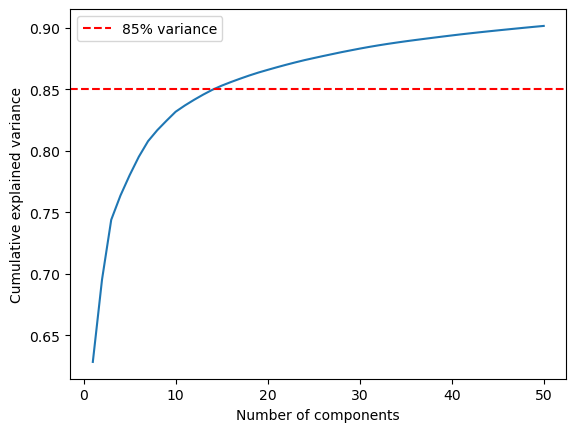

In [7]:
import matplotlib.pyplot as plt

explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained)+1), explained)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(0.85, color='r', linestyle='--', label='85% variance')
plt.legend()
plt.show()

# We choose 15 components, as they cumulatively explain >85% variance


## Visualise first 15 PCA Components

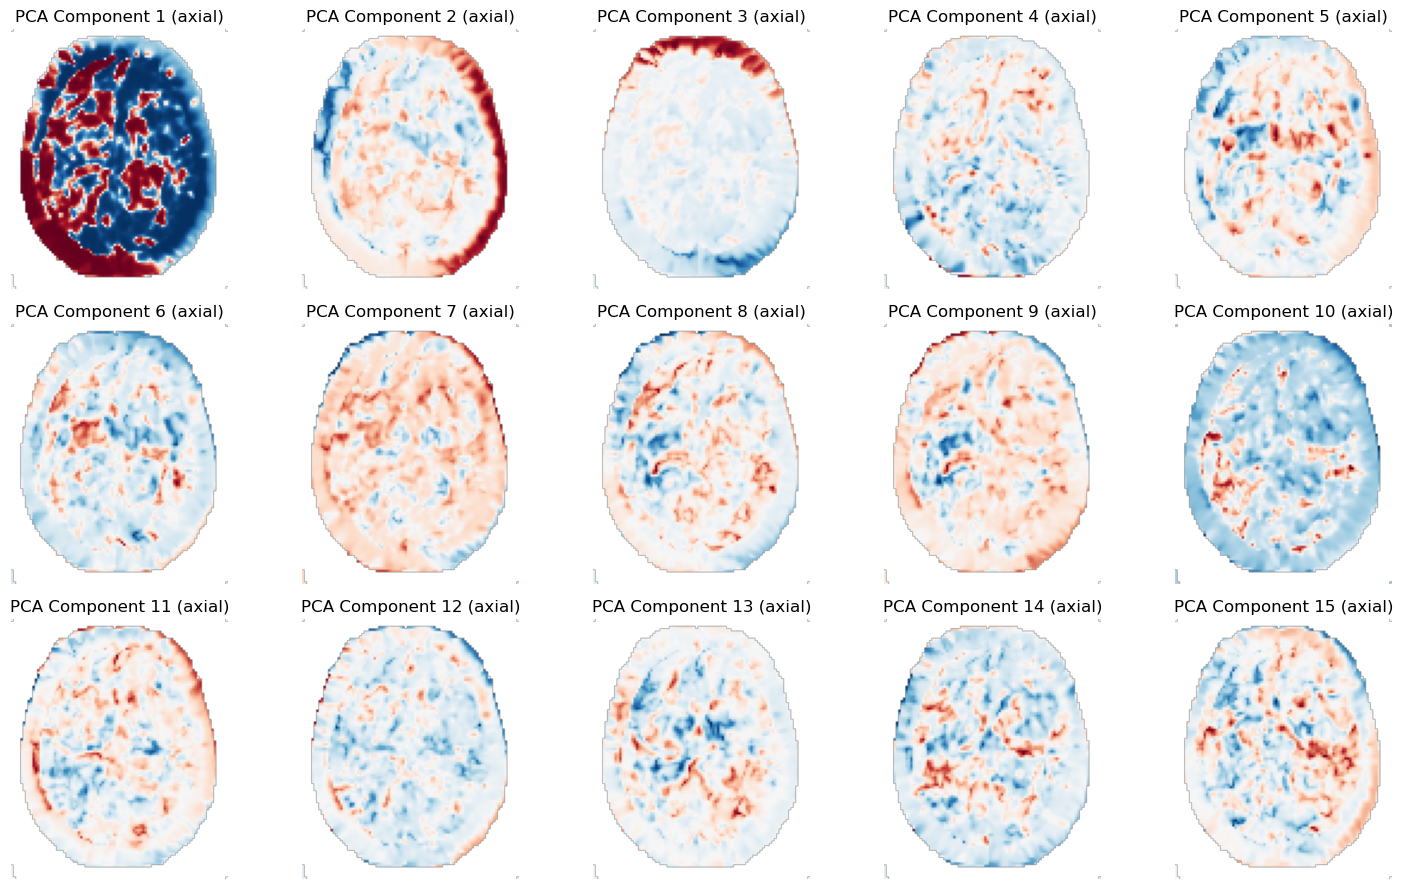

In [10]:
# Visualize Each Component (Axial view on anatomy)
# Each PCA component is a vector of voxel weights; you can reshape to the original 3D shape (using mask) for visualization.

import matplotlib.pyplot as plt

n_components=15

n_images = 15
n_cols = 5
n_rows = int(np.ceil(n_images / n_cols))

# Create figure with controlled size
plt.figure(figsize=(n_cols * 3, n_rows * 3))  # adjust 3 → larger or smaller as needed


for comp_idx in range(n_components):
    ax = plt.subplot(n_rows, n_cols, comp_idx + 1)
    weights = pca.components_[comp_idx].reshape(fmri_data.shape[:3])  # (x, y, z)
    idx = weights.shape[2] // 2 # Choose the central axial slice
    img = weights[:, :, idx].T
    mask = np.abs(img) < 1e-10
    mask = binary_dilation(binary_erosion(mask))
    masked_img = np.ma.masked_where(mask, img)
    plt.imshow(masked_img, cmap='RdBu_r', origin='lower')
    plt.axis('off')
    ax.set_title("PCA Component " + str(comp_idx+1) +" (axial)")
    ax.axis('off')

plt.tight_layout()
plt.show()


## Similarity Matrix

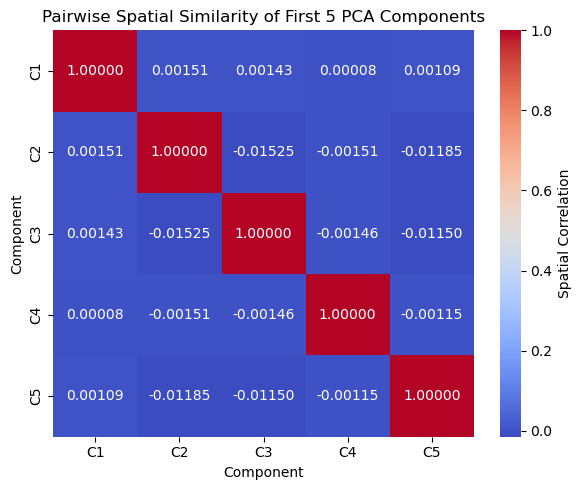

In [11]:
#Compute Pairwise Similarity Matrix for First 5 Components

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import seaborn as sns

# Extract first 5 components' spatial maps
comp_maps = pca.components_[:5]

# Compute similarity (correlation) matrix
n = comp_maps.shape[0]
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = pearsonr(comp_maps[i], comp_maps[j])[0]

plt.figure(figsize=(6, 5))
sns.heatmap(sim_matrix, annot=True, fmt=".5f", cmap="coolwarm", 
            xticklabels=[f"C{i+1}" for i in range(n)],
            yticklabels=[f"C{i+1}" for i in range(n)],
            cbar_kws={'label': 'Spatial Correlation'})

plt.title("Pairwise Spatial Similarity of First 5 PCA Components", fontsize=12)
plt.xlabel("Component")
plt.ylabel("Component")
plt.tight_layout()
plt.show()